# Characteristics of Businesses - Group Exercise

In [1]:
import pandas as pd
import requests
import warnings
warnings.filterwarnings('ignore')

tech_variables = 'https://api.census.gov/data/2018/abstcb/variables.html'
owner_variables = 'https://api.census.gov/data/2018/abscbo/variables.html'
characteristics_variables = 'https://api.census.gov/data/2018/abscb/variables.html'
company_summary_variables = 'https://api.census.gov/data/2018/abscs/variables.html'


### Tables of Variables

In [2]:
tech_vars = pd.read_html(tech_variables)[0]
owner_vars = pd.read_html(owner_variables)[0]
characteristic_vars = pd.read_html(characteristics_variables)[0]
company_summary_vars = pd.read_html(company_summary_variables)[0]

tech_vars = tech_vars[[_ for _ in tech_vars.columns[:2]]]
owner_vars = owner_vars[[_ for _ in owner_vars.columns[:2]]]
characteristic_vars = characteristic_vars[[_ for _ in characteristic_vars.columns[:2]]]
company_summary_vars = company_summary_vars[[_ for _ in company_summary_vars.columns[:2]]] 

tech_vars.rename(columns = {'Label': 'Tech Labels'}, inplace = True)
owner_vars.rename(columns = {'Label': 'Owner Labels'}, inplace = True)
characteristic_vars.rename(columns = {'Label': 'Characteristic Labels'}, inplace = True)
company_summary_vars.rename(columns = {'Label': 'Company Summary Labels'}, inplace = True)

In [3]:
grouped_tables = pd.merge(tech_vars, owner_vars, left_on = 'Name', right_on = 'Name', how = 'outer')
grouped_tables = pd.merge(grouped_tables, characteristic_vars, left_on = 'Name', right_on = 'Name', how = 'outer')
grouped_tables = pd.merge(grouped_tables, company_summary_vars , left_on = 'Name', right_on = 'Name', how = 'outer')

grouped_tables.fillna("-", inplace = True)

grouped_tables = grouped_tables[(~grouped_tables['Tech Labels'].str.contains('Standard error|standard error'))]
grouped_tables = grouped_tables[(~grouped_tables['Owner Labels'].str.contains('Standard error|standard error'))]
grouped_tables = grouped_tables[(~grouped_tables['Characteristic Labels'].str.contains('Standard error|standard error'))]
grouped_tables = grouped_tables[(~grouped_tables['Company Summary Labels'].str.contains('Standard error|standard error'))]

grouped_tables.reset_index(drop = True, inplace = True)
grouped_tables = grouped_tables[:-2].sort_values(by = 'Name')
grouped_tables = grouped_tables[(~grouped_tables['Name'].str.contains('variables'))].reset_index(drop = True)

In [4]:
vars_of_interest = [
    'NAICS2017',
    'YIBSZFI',
    'SEX',
    'QDESC',
    'NSFSZFI',
    'GEO_ID',
    'RACE_GROUP',
    'BUSCHAR',
    'OWNER_RACE',
    'OWNER_SEX'
]
target_subset = grouped_tables[(grouped_tables['Name'].isin(vars_of_interest))]
target_subset = target_subset[['Name','Company Summary Labels','Characteristic Labels','Owner Labels','Tech Labels']]

### variable strings to pass to api call


In [5]:
variable_dict = {}
for i,label in enumerate(target_subset.columns[1:]):
    variable_list = []
    for item in target_subset[(target_subset[label] != "-")].Name.tolist():
        variable_list.append(item)
        variable_list.append(f'{item}_LABEL')
    variable_list = [_ for _ in variable_list if _ not in ['GEO_ID_LABEL']]
    in_table = "NAME," + ",".join(variable_list)
    variable_dict[i] = in_table
variable_dict


{0: 'NAME,GEO_ID,NAICS2017,NAICS2017_LABEL,RACE_GROUP,RACE_GROUP_LABEL,SEX,SEX_LABEL,YIBSZFI,YIBSZFI_LABEL',
 1: 'NAME,BUSCHAR,BUSCHAR_LABEL,GEO_ID,NAICS2017,NAICS2017_LABEL,QDESC,QDESC_LABEL,RACE_GROUP,RACE_GROUP_LABEL,SEX,SEX_LABEL,YIBSZFI,YIBSZFI_LABEL',
 2: 'NAME,GEO_ID,NAICS2017,NAICS2017_LABEL,OWNER_RACE,OWNER_RACE_LABEL,OWNER_SEX,OWNER_SEX_LABEL,QDESC,QDESC_LABEL',
 3: 'NAME,GEO_ID,NAICS2017,NAICS2017_LABEL,NSFSZFI,NSFSZFI_LABEL,RACE_GROUP,RACE_GROUP_LABEL,SEX,SEX_LABEL'}

In [6]:
# Might be able to pass in the same vars for every call, and if it exists it will be returned. Not sure if this will work.
# otherwise, store the variables in a dictionary where the key is 0-3 and the values are a string of the variables

industry_code = '61'
qdesc1 = 'B27'
# links = [
#     f'https://api.census.gov/data/2018/abscs?get={variable_dict[0]}&for=state:*&NAICS2017={industry_code}',
#     f'https://api.census.gov/data/2018/abscb?get={variable_dict[1]}&for=state:*&NAICS2017={industry_code}&BUSCHAR&QDESC={qdesc1}',
#     f'https://api.census.gov/data/2018/abscbo?get={variable_dict[2]}&for=state:*&OWNCHAR=CG&NAICS2017={industry_code}&QDESC={qdesc1}',
#     f'https://api.census.gov/data/2018/abstcb?get={variable_dict[3]}&for=state:*&NAICS2017={industry_code}'
# ]
# removed from working link: GEO_ID,NAME,NAICS2017,NAICS2017_LABEL,OWNER_SEX,OWNER_SEX_LABEL,QDESC,QDESC_LABEL,OWNCHAR,OWNCHAR_LABEL
links = [
    f'https://api.census.gov/data/2018/abscs?get={variable_dict[0]},FIRMPDEMP&for=us:*', #I CHANGED THIS from for=state:*
    f'https://api.census.gov/data/2018/abscb?get={variable_dict[1]},FIRMPDEMP&for=state:*',
    f'https://api.census.gov/data/2018/abscbo?get={variable_dict[2]},OWNCHAR,OWNCHAR_LABEL&for=us:*&for=QDESC_LABEL=YRACQBUS',
    f'https://api.census.gov/data/2018/abstcb?get={variable_dict[3]},FIRMPDEMP,TECHUSE&for=state:*',
]

def get_data_frame(url):
    return pd.read_csv(url)
    
for link in links:
    print(link)
    print("")

https://api.census.gov/data/2018/abscs?get=NAME,GEO_ID,NAICS2017,NAICS2017_LABEL,RACE_GROUP,RACE_GROUP_LABEL,SEX,SEX_LABEL,YIBSZFI,YIBSZFI_LABEL,FIRMPDEMP&for=us:*

https://api.census.gov/data/2018/abscb?get=NAME,BUSCHAR,BUSCHAR_LABEL,GEO_ID,NAICS2017,NAICS2017_LABEL,QDESC,QDESC_LABEL,RACE_GROUP,RACE_GROUP_LABEL,SEX,SEX_LABEL,YIBSZFI,YIBSZFI_LABEL,FIRMPDEMP&for=state:*

https://api.census.gov/data/2018/abscbo?get=NAME,GEO_ID,NAICS2017,NAICS2017_LABEL,OWNER_RACE,OWNER_RACE_LABEL,OWNER_SEX,OWNER_SEX_LABEL,QDESC,QDESC_LABEL,OWNCHAR,OWNCHAR_LABEL&for=us:*&for=QDESC_LABEL=YRACQBUS

https://api.census.gov/data/2018/abstcb?get=NAME,GEO_ID,NAICS2017,NAICS2017_LABEL,NSFSZFI,NSFSZFI_LABEL,RACE_GROUP,RACE_GROUP_LABEL,SEX,SEX_LABEL,FIRMPDEMP,TECHUSE&for=state:*



### dataframes

In [7]:
comp_sum_df = get_data_frame(links[0]) # Company Summary
bus_char_df = business_char_df = get_data_frame(links[1]) # Business Characteristics
bus_own_df = business_own_df = get_data_frame(links[2]) # Business Owners
bus_tech_df = get_data_frame(links[3]) # Business Tech   

In [8]:
df_collection = [comp_sum_df, bus_char_df, bus_own_df, bus_tech_df]    
df_names = ['comp_sum_df', 'bus_char_df', 'bus_own_df', 'bus_tech_df']   

### Clean DataFrames

In [9]:
drop_list = [
    'race_group','sex','yibszfi','qdesc','buschar',
    'owner_race','owner_sex','us','ownchar'
]

for df in df_collection:
    column_names = [_ for _ in df.columns.tolist()]
    new_column_names = [_.replace("[[","").replace('"',"").replace("]","").lower() for _ in column_names]

    df.columns = new_column_names
    df.drop(columns = [_ for _ in new_column_names if ('unnamed' in _ or _ in drop_list)],inplace = True)
    df['name'] = df['name'].apply(lambda x: x.replace("[","").replace('"',""))
    
    if 'sex_label' in df.columns:
        df.rename(columns = {'sex_label': 'gender'}, inplace = True)
    
    if 'owner_sex_label' in df.columns:
        df.rename(columns = {'owner_sex_label': 'gender'}, inplace = True)
    
    if 'naics2017_label' in df.columns:
        df.rename(columns = {'naics2017_label': 'industry'}, inplace = True)
        
    if 'naics2017' in df.columns:
        df.rename(columns = {'naics2017': 'industry_code'}, inplace = True)

### Display some info about dataframes.

In [10]:
workingDF = df_collection[0]
workingDF = workingDF[workingDF['firmpdemp'] != 0]
workingDF = workingDF[workingDF['yibszfi_label'] == 'All firms']
workingDF = workingDF[workingDF['race_group_label'] == 'Total']

workingDF = workingDF[workingDF['industry'] != 'Industries not classified']

In [11]:
workingDF.drop(['geo_id', 'name', 'industry_code', 'race_group_label', 'yibszfi_label'], axis = 1, inplace = True)

In [12]:
workingDF = workingDF[workingDF['gender'] != 'Total']
workingDF = workingDF[workingDF['industry'] != 'Total for all sectors']
import matplotlib.pyplot as plt
import seaborn as sns


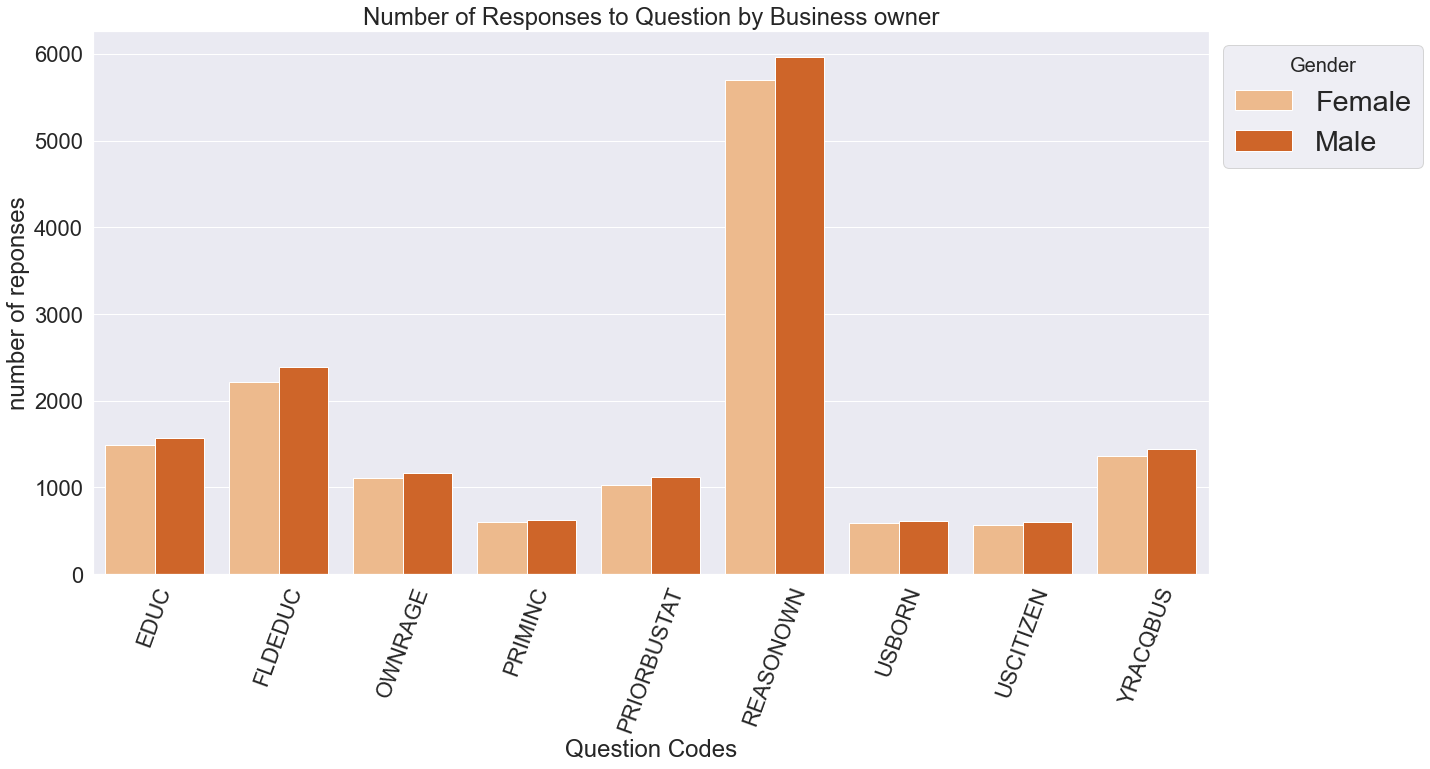

In [18]:
df_bus_own = df_collection[2]
df_bus_own[df_bus_own['industry']!='Total for all sectors']
df_bus_own = df_bus_own[df_bus_own['gender']!='All owners of respondent firms']
x = df_bus_own[['qdesc_label','gender','geo_id']].groupby(['qdesc_label','gender']).count()
x = x.reset_index()
x.columns = ['qdesc_label', 'gender', 'count']

plt.figure(figsize=(20, 10))

ax = sns.barplot(data = x, x = 'qdesc_label', y = 'count', hue = 'gender',palette = 'Oranges')
ax.set(xlabel ="Question Codes", ylabel = "number of reponses", title ='Number of Responses to Question by Business owner')
plt.legend(title = "Gender", fontsize = 'large', title_fontsize = 20, loc = 2, bbox_to_anchor = (1,1))
plt.xticks(rotation = 70)
plt.show()

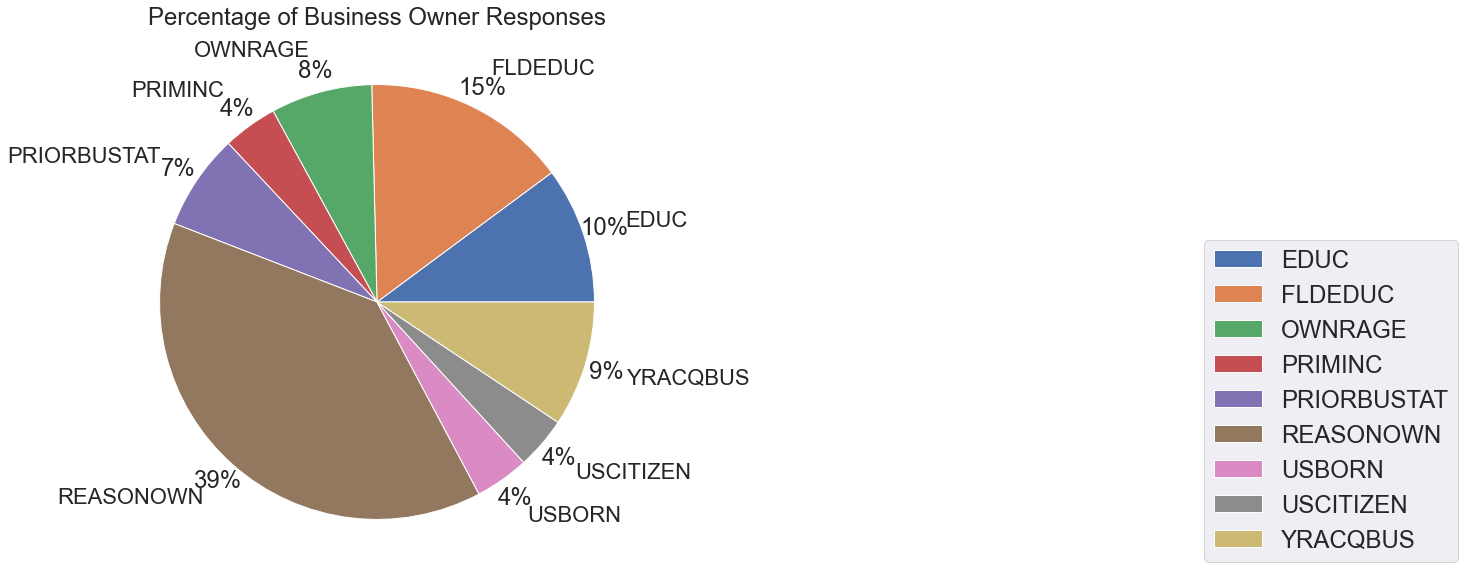

In [19]:
x = x.groupby('qdesc_label')['count'].sum().reset_index()
plt.figure(figsize=(20, 10))
plt.pie(x['count'], labels=x['qdesc_label'], autopct='%1.0f%%', pctdistance = 1.1, labeldistance = 1.2)
plt.legend(title = "", fontsize = 'medium', title_fontsize = 10, loc = 3, bbox_to_anchor = (2,0))
plt.title('Percentage of Business Owner Responses')
plt.show()

In [15]:
# x = df_bus_own[['qdesc_label','gender']].groupby(['qdesc_label']).count()
# x = x.reset_index()

# f,ax = plt.subplots(figsize=(20, 10))
# ax.plot(range(len(x)),x['gender'],color='r')
# ax.set_xticklabels(x['qdesc_label'])
# _ = plt.xticks(rotation=90)
# plt.title('Business owner Question code vs response')
# plt.xlabel('Question code')
# plt.ylabel('Total response')
# plt.show()

In [16]:
#df_bus_own['owner_race_label_min'] = df_bus_own['owner_race_label'].apply(lambda x: 'Non Minority' if x!='Minority' else x)

#x = df_bus_own[['industry','owner_race_label_min','geo_id']].groupby(['industry','owner_race_label_min']).count()
#x = x.reset_index()
#x.columns = ['industry', 'owner_race_label_min', 'count']

#plt.figure(figsize=(20, 10))

#ax = sns.barplot(data = x, x = 'industry', y = 'count', hue = 'owner_race_label_min',palette = 'Oranges')
#ax.set(xlabel ="Industry", ylabel = "Number of Owner", title ='Industry by Business Owners')
#plt.legend(title = "", fontsize = 'large', title_fontsize = 20, loc = 2, bbox_to_anchor = (1,1))
#plt.xticks(rotation = 90)
#plt.show()

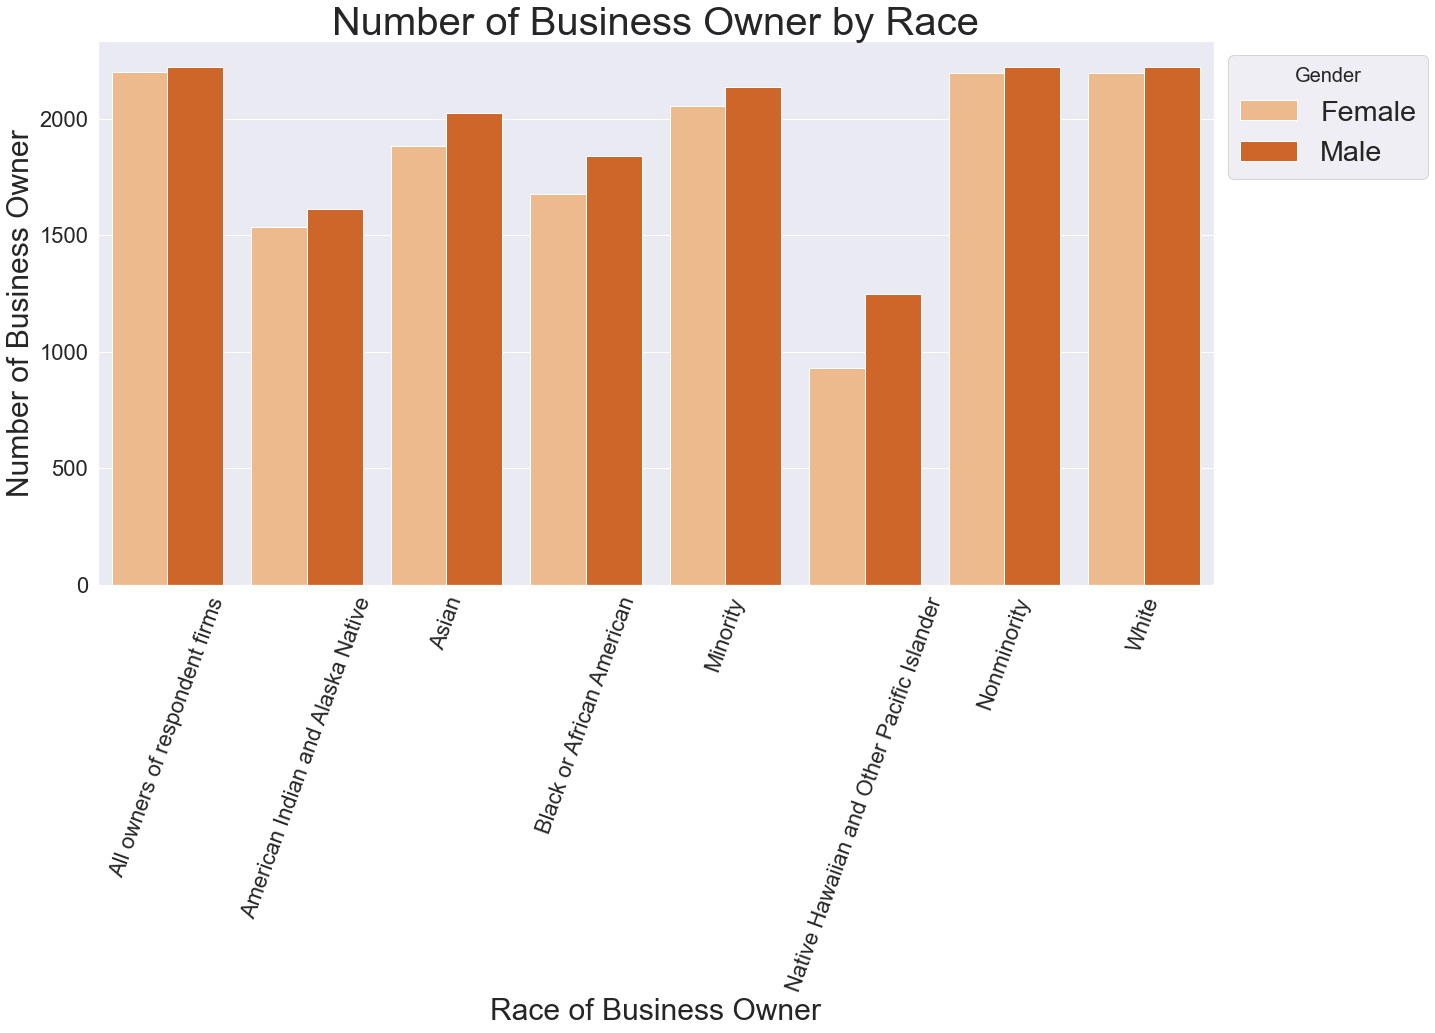

In [20]:
x = df_bus_own[['owner_race_label','gender','geo_id']].groupby(['owner_race_label','gender']).count().reset_index()

plt.figure(figsize=(20, 10))

sns.set(font_scale=2)


# ax = sns.barplot(data = x, x = 'owner_race_label', y = 'geo_id', hue = 'gender', color='green')
ax = sns.barplot(data = x, x = 'owner_race_label', y = 'geo_id', hue = 'gender', palette = 'Oranges')
# ax.set(xlabel ="Race of Business Owner", ylabel = "count", title ='Count of Business Owner by Race')
ax.set_xlabel("Race of Business Owner", fontsize = 30)
ax.set_ylabel("Number of Business Owner", fontsize = 30)
ax.set_title("Number of Business Owner by Race", fontsize = 40)

# h, l = ax.get_legend_handles_labels()
plt.legend(title = "Gender", fontsize = 'large', title_fontsize = 20, loc = 2, bbox_to_anchor = (1,1))

plt.xticks(rotation = 70)
plt.show()